In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import skopt
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

import pickle
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Data loading

df_train = pd.read_csv('data/db_train.csv')
df_test = pd.read_csv('data/db_test.csv')

X_COLS = ['MXene', 'SWNT', 'PVA']
Y_COLS = ['LRR']

X_train = df_train[X_COLS].values
y_train = df_train[Y_COLS].values.flatten()

In [4]:
# Use Grid Search Method to optimize the 'c' and 'gamma' in SVR model

search_space = {    
    'C': (1e-1, 1e+4, 'log-uniform'),
    'gamma': (1e-1, 5e+1, 'log-uniform')
}

opt = GridSearchCV(SVR(), search_space, n_jobs=16, scoring='neg_mean_absolute_error',
            cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=0))

opt.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=0),
             estimator=SVR(), n_jobs=16,
             param_grid={'C': (0.1, 10000.0, 'log-uniform'),
                         'gamma': (0.1, 50.0, 'log-uniform')},
             scoring='neg_mean_absolute_error')

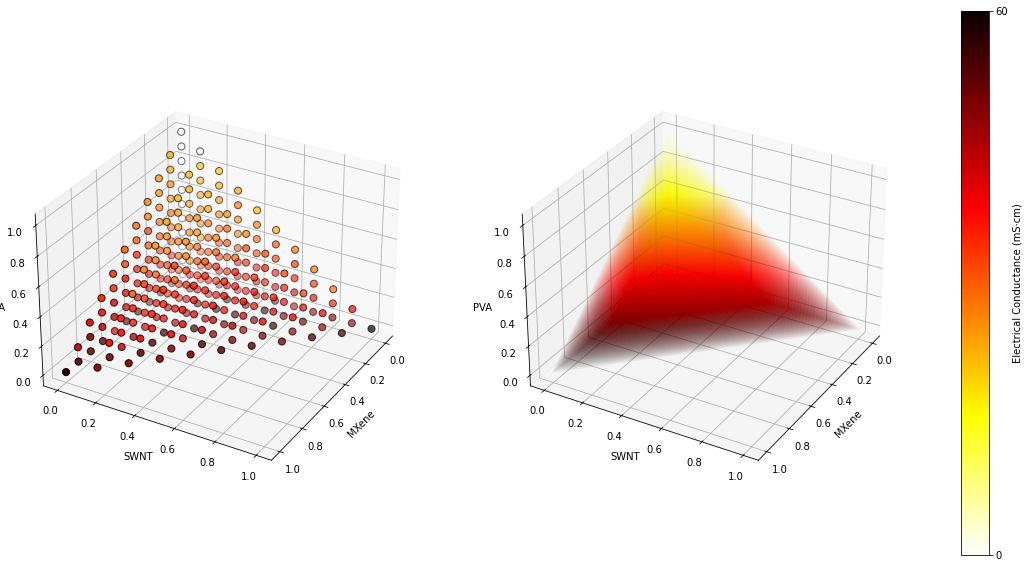

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw=dict(projection='3d'))

# Training data scatter plotting
sc = ax1.scatter(*X_train.T, c=y_train, edgecolors='black', 
                s=50, cmap=mpl.colormaps['hot_r'], marker='o')

# Set labels for axes of scatter
ax1.set_xlabel('MXene')
ax1.set_ylabel('SWNT')
ax1.set_zlabel('PVA')

# Generate grid points in the whole design space
num_points = 128
grid_space = 1 / (num_points - 1)
x, y, z = np.mgrid[0:1:num_points*1j, 0:1:num_points*1j, 0:1:num_points*1j]
xyz = np.array([x.flatten(), y.flatten(), z.flatten()]).T
xyz = xyz[xyz.sum(axis=1) <= 1.0]
prob = opt.predict(xyz)

# Heatmap plotting
ss = ax2.scatter(*xyz.T, c=prob, s=1.0, alpha=0.03, cmap=mpl.colormaps['hot_r'])

# Set labels for axes
ax2.set_xlabel('MXene')
ax2.set_ylabel('SWNT')
ax2.set_zlabel('PVA')

# Set labels for color bars
cbar = plt.colorbar(sc, ax=[ax1, ax2], orientation='vertical')
cbar.set_ticks([y_train.min(), y_train.max()])
cbar.set_ticklabels(['0', '60'])
cbar.set_label('Electrical Conductance (mS\u22C5cm)')

# Show the plot
ax1.view_init(30, 30)
ax2.view_init(30, 30)